In [10]:
import pandas as pd
import numpy as np


def gamma_hedge_backtest_new_pnl(
    df,
    price_col="price",
    gamma=10.0,
    delta_threshold=1000.0,
    contract_multiplier=50.0,
    fee_per_contract=10.0,
    s_ref=None,
 ):
    """
    Gamma hedge backtest with:
      - Integer futures hedging (rounded contracts)
      - Daily reset of ref price and futures position
      - Gamma PnL: 0.5 * gamma * (S_t - day_open)^2  (no multiplier)
      - Hedge PnL: cumulative futures PnL minus transaction costs
      - Futures transaction cost: fee_per_contract per contract change
      - Tracks number of hedge trades (futures adjustments) and trade prices
    Returns: dict with total_pnl, gamma_pnl, hedge_pnl, equity_curve, details, hedge_trades
    """
    df = df.copy()

    # Ensure time column exists and avoid index/column name clash
    if "time" not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df["time"] = df.index
        else:
            raise ValueError("DataFrame must have a 'time' column or a DatetimeIndex.")
    if df.index.name == "time":
        df.index.name = "time_index"

    df = df.sort_values("time")

    groups = df.groupby(df["time"].dt.date)

    total_gamma_pnl = 0.0
    cum_hedge_pnl = 0.0
    hedge_trades = 0  # count futures adjustments

    equity_list = []
    equity_index = []
    records = []

    for _, group in groups:
        group = group.sort_values("time")
        prices = group[price_col].values
        times = group["time"].values
        if len(prices) < 1:
            continue

        day_open = float(prices[0])
        fut_pos = 0.0
        last_price = day_open

        for i in range(len(prices)):
            t = times[i]
            price_now = float(prices[i])
            dS = price_now - last_price

            cum_hedge_pnl += fut_pos * dS * contract_multiplier

            day_gamma_pnl = 0.5 * gamma * (price_now - day_open) ** 2

            opt_delta = gamma * (price_now - day_open)
            fut_delta = fut_pos * contract_multiplier
            total_delta = opt_delta + fut_delta

            trade_size = 0
            trade_price = np.nan
            if abs(total_delta) >= delta_threshold:
                ideal_fut_pos = -opt_delta / contract_multiplier
                target_fut_pos = round(ideal_fut_pos)
                if target_fut_pos != fut_pos:
                    trade_size = abs(target_fut_pos - fut_pos)
                    trade_price = price_now
                    fut_pos = target_fut_pos
                    fut_delta = fut_pos * contract_multiplier
                    total_delta = opt_delta + fut_delta
                    hedge_trades += trade_size  # count contracts traded
                    # Subtract transaction cost for contract changes
                    cum_hedge_pnl -= trade_size * fee_per_contract

            # Current totals
            gamma_total = total_gamma_pnl + day_gamma_pnl
            total_equity = gamma_total + cum_hedge_pnl

            equity_list.append(total_equity)
            equity_index.append(t)

            records.append({
                "time": t,
                "price": price_now,
                "day_s_ref": day_open,
                "opt_delta": opt_delta,
                "fut_pos": fut_pos,
                "total_delta": total_delta,
                "day_gamma_pnl": day_gamma_pnl,
                "gamma_pnl": gamma_total,
                "hedge_pnl": cum_hedge_pnl,
                "equity": total_equity,
                "trade_size": trade_size,
                "trade_price": trade_price,
            })

            last_price = price_now

        # Lock in end-of-day gamma PnL
        final_day_gamma = 0.5 * gamma * (last_price - day_open) ** 2
        total_gamma_pnl += final_day_gamma

    equity_curve = pd.Series(equity_list, index=equity_index)
    details_df = pd.DataFrame(records).set_index("time")

    result = {
        "total_pnl": float(total_gamma_pnl + cum_hedge_pnl),
        "gamma_pnl": float(total_gamma_pnl),
        "hedge_pnl": float(cum_hedge_pnl),
        "hedge_trades": int(hedge_trades),
        "equity_curve": equity_curve,
        "details": details_df,
    }
    return result

In [11]:
df = pd.read_pickle('../data/txo_vix_all.pkl')
df = df.sort_values("time").reset_index(drop=True)
# The following line was filtering out data from Sep-Dec (month >= 9). 
# Commenting it out to include 2024/09-12 data as requested.
# df = df[df['time'].dt.month < 9].reset_index(drop=True)

df3 = pd.read_pickle('../data/TXF_H1.pkl')
df4 = pd.read_pickle('../data/TXF_H2.pkl')
df5 = pd.read_pickle('../data/TXF_2024H2.pkl')
# Merge H1 and H2, then filter before September and sort by time/index
df2 = pd.concat([df3, df4,df5]).sort_index()

In [12]:
df5

mkt_mid               contract
time                                               
2024-09-02 09:00:00  22417.5  FUT_TAIFEX_TXF:202409
2024-09-02 09:01:00  22425.5  FUT_TAIFEX_TXF:202409
2024-09-02 09:02:00  22431.5  FUT_TAIFEX_TXF:202409
2024-09-02 09:03:00  22417.5  FUT_TAIFEX_TXF:202409
2024-09-02 09:04:00  22409.5  FUT_TAIFEX_TXF:202409
...                      ...                    ...
2024-12-31 13:40:00  23045.5  FUT_TAIFEX_TXF:202501
2024-12-31 13:41:00  23047.5  FUT_TAIFEX_TXF:202501
2024-12-31 13:42:00  23046.0  FUT_TAIFEX_TXF:202501
2024-12-31 13:43:00  23044.0  FUT_TAIFEX_TXF:202501
2024-12-31 13:44:00  23043.5  FUT_TAIFEX_TXF:202501

[23310 rows x 2 columns]

In [13]:
df2

mkt_mid               contract
time                                               
2024-09-02 09:00:00  22417.5  FUT_TAIFEX_TXF:202409
2024-09-02 09:01:00  22425.5  FUT_TAIFEX_TXF:202409
2024-09-02 09:02:00  22431.5  FUT_TAIFEX_TXF:202409
2024-09-02 09:03:00  22417.5  FUT_TAIFEX_TXF:202409
2024-09-02 09:04:00  22409.5  FUT_TAIFEX_TXF:202409
...                      ...                    ...
2025-09-19 13:40:00  25697.0  FUT_TAIFEX_TXF:202510
2025-09-19 13:41:00  25687.5  FUT_TAIFEX_TXF:202510
2025-09-19 13:42:00  25684.0  FUT_TAIFEX_TXF:202510
2025-09-19 13:43:00  25677.5  FUT_TAIFEX_TXF:202510
2025-09-19 13:44:00  25672.5  FUT_TAIFEX_TXF:202510

[69363 rows x 2 columns]

In [14]:
def run_gamma_hedge_new_pnl_thresholds(
    df,
    price_col="price",
    gamma=10.0,
    delta_thresholds=(0.0, 200,400,600, 800,1000.0,1200,1400,1600, 2000.0),
    contract_multiplier=50.0,
    s_ref=None,
 ):
    """
    Run the new gamma-hedge PnL backtest for multiple delta thresholds.
    Returns a summary DataFrame and a dict of full results.
    """
    summary = []
    all_results = {}

    for th in delta_thresholds:
        res = gamma_hedge_backtest_new_pnl(
            df=df,
            price_col=price_col,
            gamma=gamma,
            delta_threshold=th,
            contract_multiplier=contract_multiplier,
            s_ref=s_ref,
        )
        all_results[th] = res
        summary.append({
            "delta_threshold": th,
            "total_pnl": res["total_pnl"],
            "gamma_pnl": res["gamma_pnl"],
            "hedge_pnl": res["hedge_pnl"],
        })

    summary_df = pd.DataFrame(summary).set_index("delta_threshold").sort_index()
    return summary_df, all_results

def gamma_hedge_backtest_periodic(
    df,
    price_col="price",
    gamma=10.0,
    min_delta_to_hedge=50.0,
    contract_multiplier=50.0,
    fee_per_contract=10.0,
    interval_minutes=60
):
    """
    Gamma hedge backtest with periodic rebalancing (time-based).
    """
    df = df.copy()
    
    if df.index.name == "time":
        df.index.name = "time_index"

    if "time" not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df["time"] = df.index
        else:
            raise ValueError("DataFrame must have a 'time' column or a DatetimeIndex.")
            
    df = df.sort_values("time")
    groups = df.groupby(df["time"].dt.date)

    total_gamma_pnl = 0.0
    cum_hedge_pnl = 0.0
    hedge_trades = 0

    equity_list = []
    equity_index = []
    records = []

    for _, group in groups:
        group = group.sort_values("time")
        prices = group[price_col].values
        times = group["time"].values
        
        # Pre-calculate period IDs for speed
        dt_index = pd.to_datetime(times)
        minutes_of_day = dt_index.hour * 60 + dt_index.minute
        period_ids = minutes_of_day // interval_minutes
        
        if len(prices) < 1:
            continue

        day_open = float(prices[0])
        fut_pos = 0.0
        last_price = day_open
        last_period_id = period_ids[0]

        for i in range(len(prices)):
            t = times[i]
            price_now = float(prices[i])
            dS = price_now - last_price

            # PnL Updates
            cum_hedge_pnl += fut_pos * dS * contract_multiplier
            day_gamma_pnl = 0.5 * gamma * (price_now - day_open) ** 2

            # Delta Calculation
            opt_delta = gamma * (price_now - day_open)
            fut_delta = fut_pos * contract_multiplier
            total_delta = opt_delta + fut_delta

            # Periodic Hedge Logic
            current_period_id = period_ids[i]
            is_period_change = (current_period_id != last_period_id)
            
            trade_size = 0
            
            if is_period_change:
                if abs(total_delta) >= min_delta_to_hedge:
                    ideal_fut_pos = -opt_delta / contract_multiplier
                    target_fut_pos = round(ideal_fut_pos)
                    
                    if target_fut_pos != fut_pos:
                        trade_size = abs(target_fut_pos - fut_pos)
                        fut_pos = target_fut_pos
                        
                        fut_delta = fut_pos * contract_multiplier
                        total_delta = opt_delta + fut_delta
                        
                        hedge_trades += trade_size
                        cum_hedge_pnl -= trade_size * fee_per_contract
                
                last_period_id = current_period_id

            # Record
            gamma_total = total_gamma_pnl + day_gamma_pnl
            total_equity = gamma_total + cum_hedge_pnl

            equity_list.append(total_equity)
            equity_index.append(t)
            
            records.append({
                "time": t,
                "price": price_now,
                "total_delta": total_delta,
                "hedge_pnl": cum_hedge_pnl,
                "equity": total_equity,
                "trade_size": trade_size
            })

            last_price = price_now

        final_day_gamma = 0.5 * gamma * (last_price - day_open) ** 2
        total_gamma_pnl += final_day_gamma

    return {
        "total_pnl": float(total_gamma_pnl + cum_hedge_pnl),
        "gamma_pnl": float(total_gamma_pnl),
        "hedge_pnl": float(cum_hedge_pnl),
        "hedge_trades": int(hedge_trades),
        "equity_curve": pd.Series(equity_list, index=equity_index),
        "details": pd.DataFrame(records).set_index("time"),
    }

In [15]:
price_col = "mkt_mid" if "mkt_mid" in df2.columns else ("price" if "price" in df2.columns else None)
if price_col is None:
    raise ValueError("Price column not found in df2 (expected 'mkt_mid' or 'price').")
thresholds = [50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 400.0, 500.0]
summary_df, all_results = run_gamma_hedge_new_pnl_thresholds(
    df=df2,
    price_col=price_col,
    gamma=10.0,
    delta_thresholds=thresholds,
    contract_multiplier=50.0,
 )

default_th = 200.0
details = all_results[default_th]["details"]
res_selected = all_results[default_th]
print(summary_df)

                   total_pnl    gamma_pnl  hedge_pnl
delta_threshold                                     
50.0             29955291.25  39839111.25 -9883820.0
100.0            30153461.25  39839111.25 -9685650.0
150.0            30401941.25  39839111.25 -9437170.0
200.0            30433486.25  39839111.25 -9405625.0
250.0            30347446.25  39839111.25 -9491665.0
300.0            30397221.25  39839111.25 -9441890.0
400.0            30628566.25  39839111.25 -9210545.0
500.0            30733736.25  39839111.25 -9105375.0


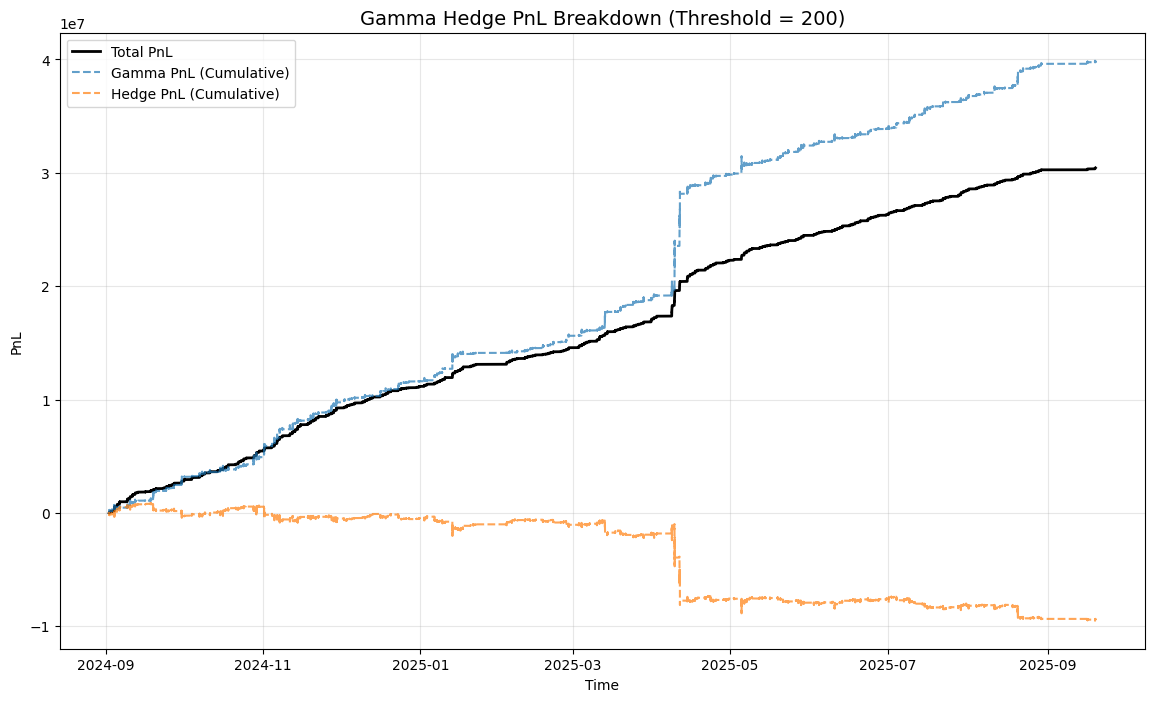

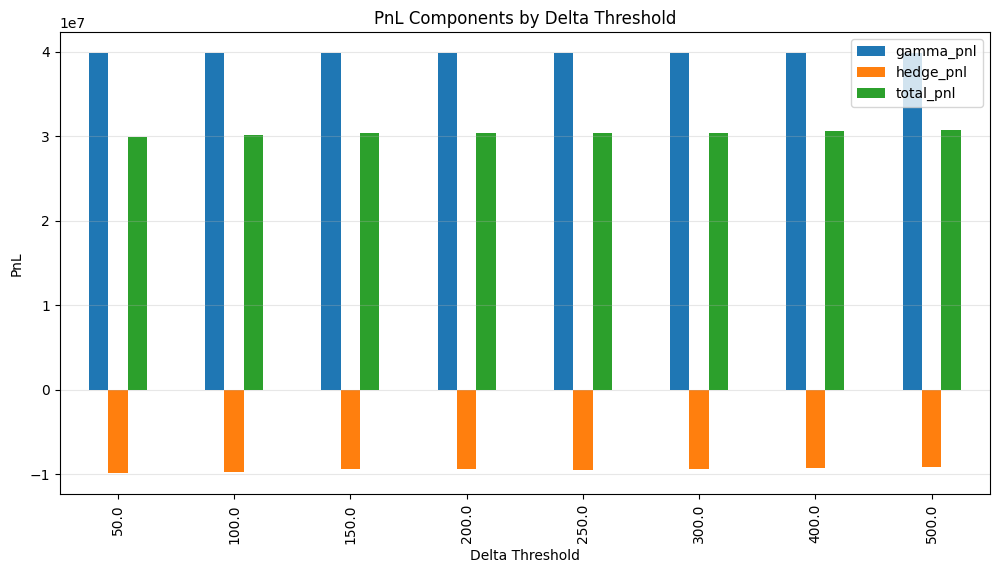

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

plt.plot(details.index, details['equity'], label='Total PnL', linewidth=2, color='black')
plt.plot(details.index, details['gamma_pnl'], label='Gamma PnL (Cumulative)', linestyle='--', alpha=0.7)
plt.plot(details.index, details['hedge_pnl'], label='Hedge PnL (Cumulative)', linestyle='--', alpha=0.7)

plt.title('Gamma Hedge PnL Breakdown (Threshold = 200)', fontsize=14)
plt.xlabel('Time')
plt.ylabel('PnL')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))
summary_df[['gamma_pnl', 'hedge_pnl', 'total_pnl']].plot(kind='bar', ax=plt.gca())
plt.title('PnL Components by Delta Threshold')
plt.ylabel('PnL')
plt.xlabel('Delta Threshold')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

Running Periodic Strategies for comparison...


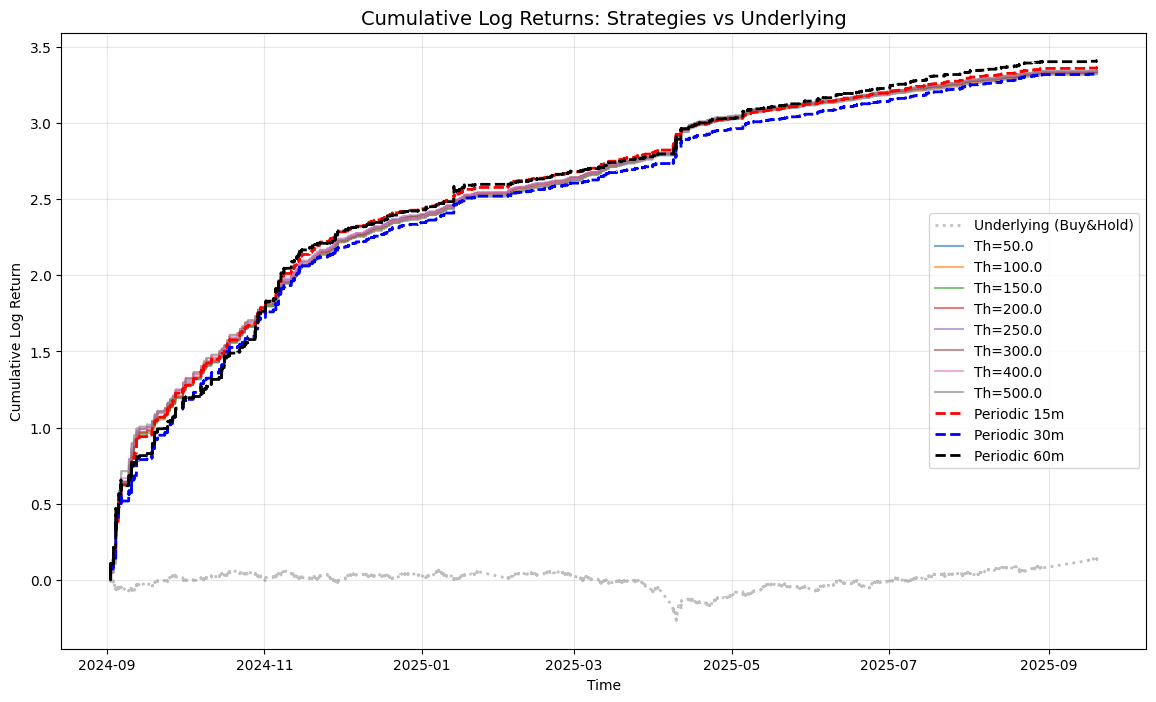

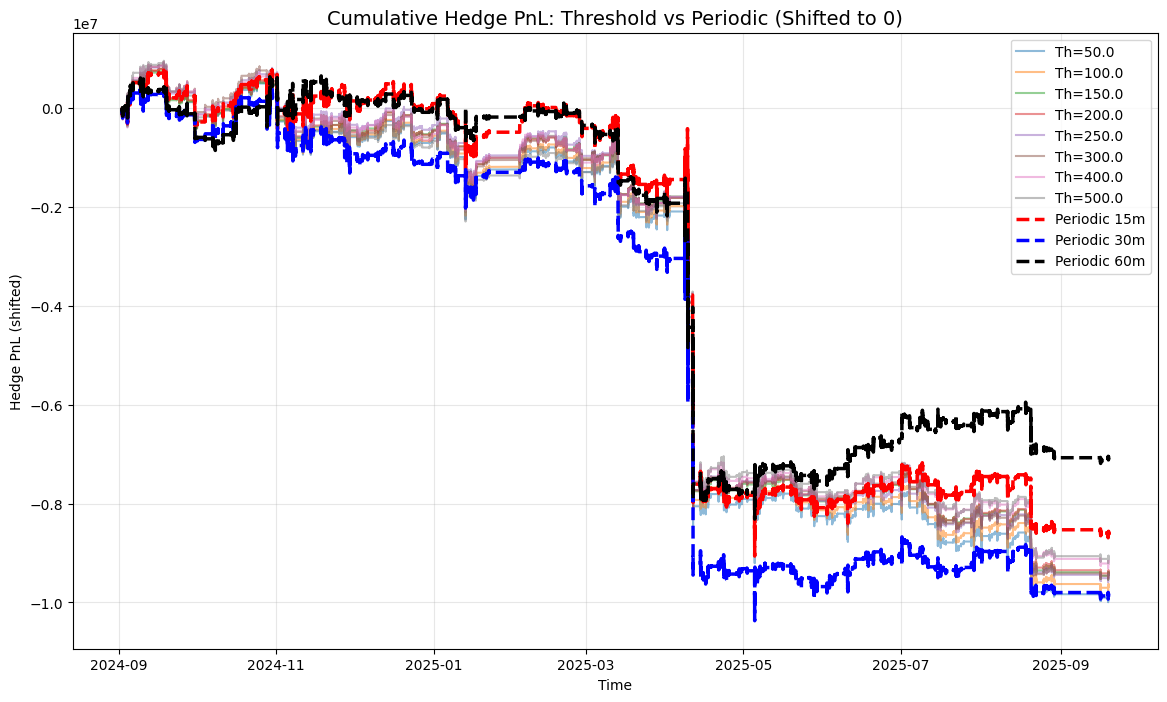

Total PnL Stats (Equity):
              step_pnl_std  step_pnl_mean  cumulative_pnl  \
threshold                                                   
50.0           1413.203432     431.868909     29955291.25   
100.0          1460.751877     434.725949     30153461.25   
150.0          1541.118190     438.308314     30401941.25   
200.0          1644.988373     438.763102     30433486.25   
250.0          1780.163235     437.522653     30347446.25   
300.0          1889.162007     438.240265     30397221.25   
400.0          2218.677539     441.575593     30628566.25   
500.0          2589.842606     443.091841     30733736.25   
Periodic 15m   4630.368402     449.984231     31211806.25   
Periodic 30m   5979.134460     431.859249     29954621.25   
Periodic 60m   8645.887183     471.699075     32717991.25   

              cumulative_log_return  
threshold                            
50.0                       3.322332  
100.0                      3.328688  
150.0                      3

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure price_col is defined
price_col = "mkt_mid" if "mkt_mid" in df2.columns else "price"

# --- Run Periodic Strategies for Comparison ---
periodic_intervals = [15, 30, 60]
periodic_results = {}

print("Running Periodic Strategies for comparison...")
for mins in periodic_intervals:
    periodic_results[mins] = gamma_hedge_backtest_periodic(
        df=df2,
        price_col=price_col,
        gamma=10.0,
        min_delta_to_hedge=50.0,
        contract_multiplier=50.0,
        interval_minutes=mins
    )

# --- Plot 1: Equity Curves as Log Returns (Threshold vs Periodic vs Underlying) ---
plt.figure(figsize=(14, 8))

# Base Capital for Log Return Calculation (Approximate Notional)
initial_price = df2[price_col].iloc[0]
contract_multiplier = 50.0
initial_capital = initial_price * contract_multiplier

# 1. Plot Underlying Buy & Hold Log Return
underlying_log_ret = np.log(df2[price_col] / initial_price)
plt.plot(df2.index, underlying_log_ret, label='Underlying (Buy&Hold)', color='gray', alpha=0.5, linewidth=2, linestyle=':')

# 2. Plot Threshold Strategies
smooth_stats = []
hedge_stats_list = [] # New list for hedge pnl stats

for th, res in all_results.items():
    # --- Equity / Total PnL Stats ---
    curve = res["equity_curve"].copy()
    log_ret_curve = np.log(1 + curve / initial_capital)
    plt.plot(log_ret_curve.index, log_ret_curve.values, label=f"Th={th}", alpha=0.6)

    step_pnl = curve.diff().dropna()
    cum_pnl = res["total_pnl"]
    cum_log_ret = log_ret_curve.iloc[-1] if not log_ret_curve.empty else 0.0
    
    smooth_stats.append({
        "threshold": th,
        "step_pnl_mean": step_pnl.mean(),
        "step_pnl_std": step_pnl.std(),
        "cumulative_pnl": cum_pnl,
        "cumulative_log_return": cum_log_ret
    })

    # --- Hedge PnL Stats ---
    if 'details' in res and 'hedge_pnl' in res['details']:
        h_curve = res['details']['hedge_pnl'].copy()
        
        # Step PnL: Include the first step (change from 0)
        step_hedge_pnl = h_curve.diff()
        if not h_curve.empty:
            step_hedge_pnl.iloc[0] = h_curve.iloc[0]
        
        cum_hedge_pnl = res['hedge_pnl']
        
        # Scalar calculation for Cumulative Log Return
        # ln( (InitialCapital + TotalHedgePnL) / InitialCapital )
        if initial_capital > 0:
             val = 1 + cum_hedge_pnl / initial_capital
             cum_hedge_log_ret = np.log(max(val, 1e-9))
        else:
             cum_hedge_log_ret = 0.0

        hedge_stats_list.append({
            "threshold": th,
            "step_pnl_mean": step_hedge_pnl.mean(),
            "step_pnl_std": step_hedge_pnl.std(),
            "cumulative_pnl": cum_hedge_pnl,
            "cumulative_log_return": cum_hedge_log_ret
        })

# 3. Plot Periodic Strategies
periodic_colors = {15: 'red', 30: 'blue', 60: 'black'}
for mins, res in periodic_results.items():
    # --- Equity / Total PnL Stats ---
    curve = res["equity_curve"].copy()
    log_ret_curve = np.log(1 + curve / initial_capital)
    
    plt.plot(log_ret_curve.index, log_ret_curve.values, 
             label=f"Periodic {mins}m", 
             color=periodic_colors.get(mins, 'green'), 
             linewidth=2.0, linestyle='--')

    step_pnl = curve.diff().dropna()
    cum_pnl = res["total_pnl"]
    cum_log_ret = log_ret_curve.iloc[-1] if not log_ret_curve.empty else 0.0
    
    smooth_stats.append({
        "threshold": f"Periodic {mins}m",
        "step_pnl_mean": step_pnl.mean(),
        "step_pnl_std": step_pnl.std(),
        "cumulative_pnl": cum_pnl,
        "cumulative_log_return": cum_log_ret
    })

    # --- Hedge PnL Stats ---
    if 'details' in res and 'hedge_pnl' in res['details']:
        h_curve = res['details']['hedge_pnl'].copy()
        
        # Step PnL: Include the first step (change from 0)
        step_hedge_pnl = h_curve.diff()
        if not h_curve.empty:
            step_hedge_pnl.iloc[0] = h_curve.iloc[0]
            
        cum_hedge_pnl = res['hedge_pnl']
        
        # Scalar calculation for Cumulative Log Return
        if initial_capital > 0:
             val = 1 + cum_hedge_pnl / initial_capital
             cum_hedge_log_ret = np.log(max(val, 1e-9))
        else:
             cum_hedge_log_ret = 0.0

        hedge_stats_list.append({
            "threshold": f"Periodic {mins}m",
            "step_pnl_mean": step_hedge_pnl.mean(),
            "step_pnl_std": step_hedge_pnl.std(),
            "cumulative_pnl": cum_hedge_pnl,
            "cumulative_log_return": cum_hedge_log_ret
        })

plt.title("Cumulative Log Returns: Strategies vs Underlying", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Plot 2: Cumulative Hedge PnL (Shifted to 0) - Threshold vs Periodic ---
plt.figure(figsize=(14, 8))

# Plot Thresholds (Background)
for th, res in all_results.items():
    if 'details' in res and 'hedge_pnl' in res['details']:
        h_curve = res['details']['hedge_pnl'].copy()
        if not h_curve.empty:
            # Shift to start at 0 for visual comparability of cost accumulation
            h_curve = h_curve - h_curve.iloc[0]
            plt.plot(h_curve.index, h_curve.values, label=f"Th={th}", alpha=0.5, linewidth=1.5)

# Plot Periodic (Foreground)
for mins, res in periodic_results.items():
    if 'details' in res and 'hedge_pnl' in res['details']:
        h_curve = res['details']['hedge_pnl'].copy()
        if not h_curve.empty:
            h_curve = h_curve - h_curve.iloc[0]
            plt.plot(h_curve.index, h_curve.values, 
                     label=f"Periodic {mins}m", 
                     color=periodic_colors.get(mins, 'green'), 
                     linewidth=2.5, linestyle='--')

plt.title("Cumulative Hedge PnL: Threshold vs Periodic (Shifted to 0)", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Hedge PnL (shifted)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Display Stats Tables
smooth_df = pd.DataFrame(smooth_stats).set_index("threshold")
print("Total PnL Stats (Equity):")
print(smooth_df[["step_pnl_std", "step_pnl_mean", "cumulative_pnl", "cumulative_log_return"]])


In [18]:
smooth_df

step_pnl_mean  step_pnl_std  cumulative_pnl  \
threshold                                                   
50.0             431.868909   1413.203432     29955291.25   
100.0            434.725949   1460.751877     30153461.25   
150.0            438.308314   1541.118190     30401941.25   
200.0            438.763102   1644.988373     30433486.25   
250.0            437.522653   1780.163235     30347446.25   
300.0            438.240265   1889.162007     30397221.25   
400.0            441.575593   2218.677539     30628566.25   
500.0            443.091841   2589.842606     30733736.25   
Periodic 15m     449.984231   4630.368402     31211806.25   
Periodic 30m     431.859249   5979.134460     29954621.25   
Periodic 60m     471.699075   8645.887183     32717991.25   

              cumulative_log_return  
threshold                            
50.0                       3.322332  
100.0                      3.328688  
150.0                      3.336602  
200.0                      3.337602  
250.0                      3.334872  
300.0                      3.336452  
400.0                      3.343765  
500.0                      3.347073  
Periodic 15m               3.361969  
Periodic 30m               3.322310  
Periodic 60m               3.407500

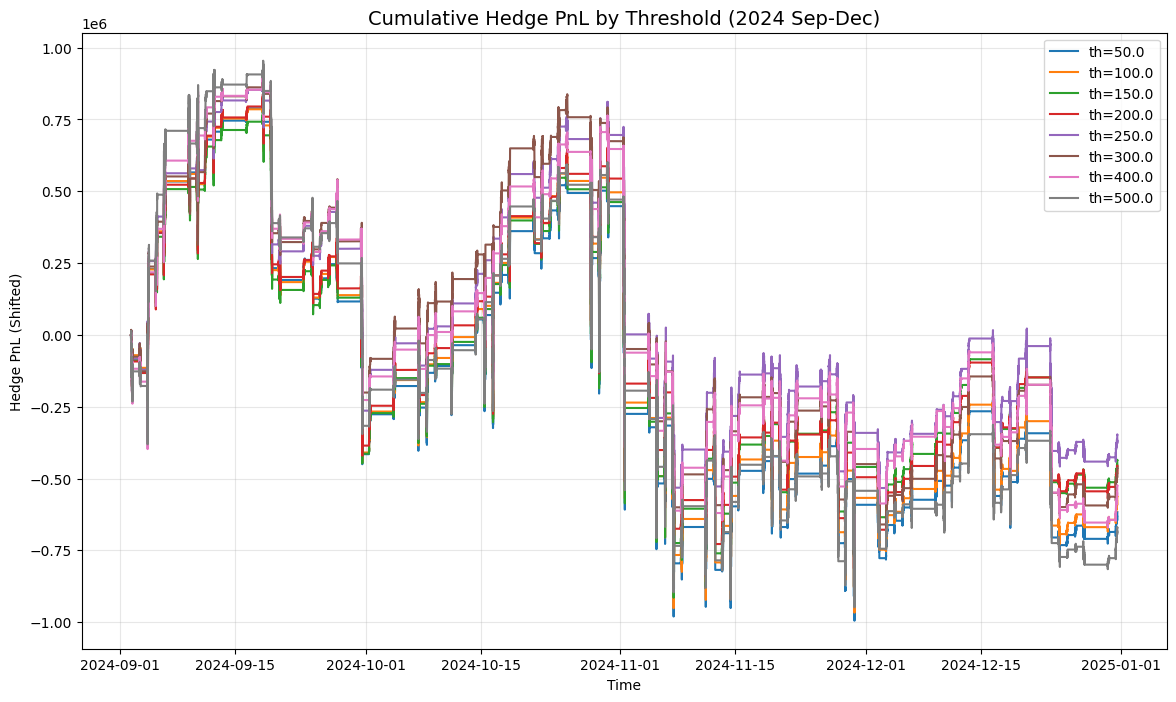

Stats for 2024 Sep-Dec:
           period_hedge_pnl  period_trades  cost_per_trade
threshold                                                 
50.0              -616650.0        28400.0      -21.713028
100.0             -561915.0        22529.0      -24.941853
150.0             -435315.0        18359.0      -23.711259
200.0             -455340.0        15204.0      -29.948698
250.0             -346825.0        13020.0      -26.637865
300.0             -462635.0        11336.0      -40.811133
400.0             -523835.0         8831.0      -59.317744
500.0             -670200.0         7245.0      -92.505176
--------------------------------------------------


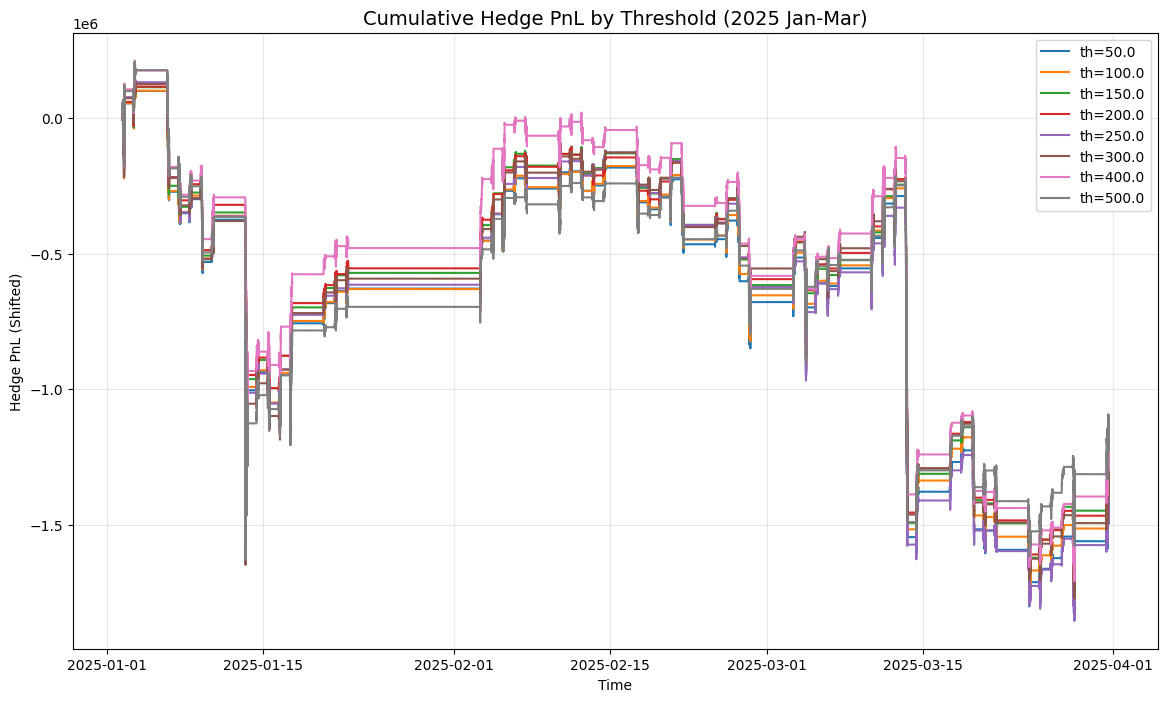

Stats for 2025 Jan-Mar:
           period_hedge_pnl  period_trades  cost_per_trade
threshold                                                 
50.0             -1429795.0        16307.0      -87.679831
100.0            -1377190.0        12659.0     -108.791374
150.0            -1318255.0        10193.0     -129.329442
200.0            -1337265.0         8384.0     -159.502028
250.0            -1421590.0         7044.0     -201.815730
300.0            -1344700.0         6150.0     -218.650407
400.0            -1243645.0         4952.0     -251.139943
500.0            -1178475.0         4160.0     -283.287260
--------------------------------------------------


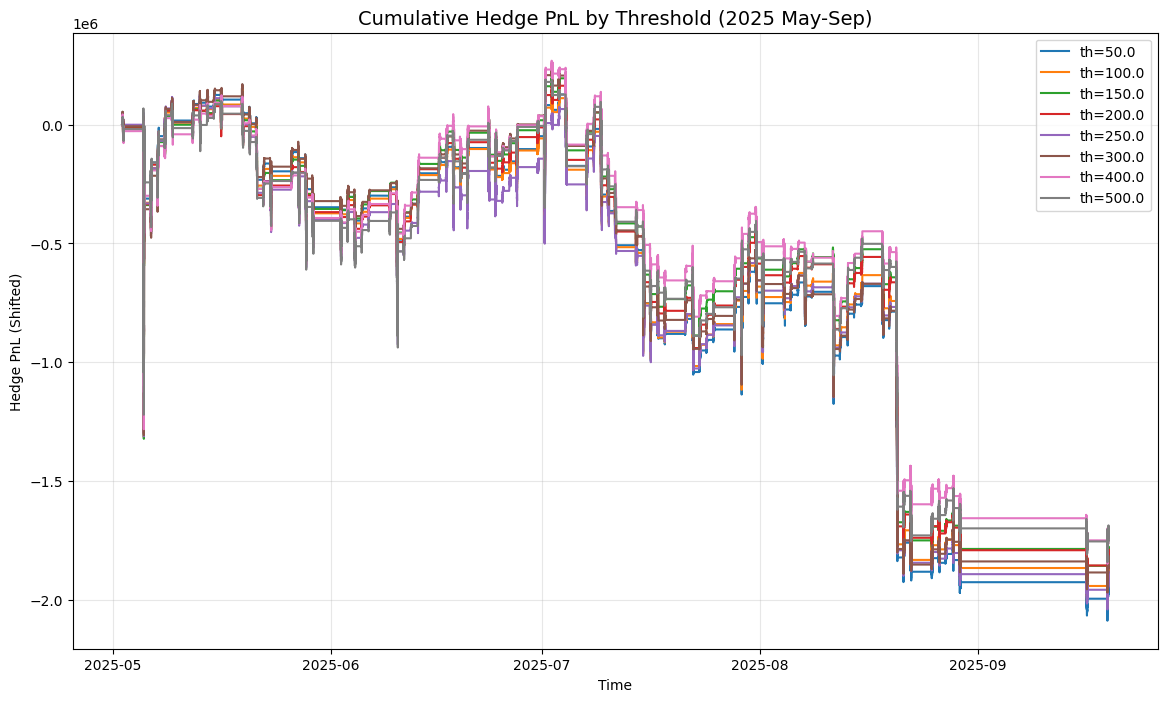

Stats for 2025 May-Sep:
           period_hedge_pnl  period_trades  cost_per_trade
threshold                                                 
50.0             -1976820.0        23082.0      -85.643358
100.0            -1924160.0        17496.0     -109.977138
150.0            -1834765.0        13984.0     -131.204591
200.0            -1848960.0        11441.0     -161.608251
250.0            -1941560.0         9701.0     -200.140192
300.0            -1867580.0         8488.0     -220.025919
400.0            -1747610.0         6791.0     -257.342070
500.0            -1740405.0         5578.0     -312.012370
--------------------------------------------------


In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Focus on Hedge PnL: Compare which threshold loses the least amount of money on hedging
# Split into 3 specific periods: 2024/09-12, 2025/01-03, 2025/05-09

if 'all_results' in locals():
    # Define periods with filter functions
    periods = [
        ("2024 Sep-Dec", lambda x: (x.year == 2024) & (x.month.isin([9, 10, 11, 12]))),
        ("2025 Jan-Mar", lambda x: (x.year == 2025) & (x.month.isin([1, 2, 3]))),
        ("2025 May-Sep", lambda x: (x.year == 2025) & (x.month.isin([5, 6, 7, 8, 9])))
    ]

    for period_name, filter_func in periods:
        plt.figure(figsize=(14, 8))
        hedge_stats = []
        
        # Check if we have data for this period
        has_data = False

        for th, res in all_results.items():
            # Get details and filter by period
            details = res["details"].copy()
            mask = filter_func(details.index)
            period_details = details.loc[mask]
            
            if period_details.empty:
                continue
            
            has_data = True
                
            # Cumulative Hedge PnL curve for this period
            # Shift to start at 0 for comparison
            h_curve = period_details["hedge_pnl"]
            h_curve = h_curve - h_curve.iloc[0]
            
            plt.plot(h_curve.index, h_curve.values, label=f"th={th}")
            
            # Calculate stats for this period
            period_trades = period_details["trade_size"].sum()
            period_pnl = h_curve.iloc[-1] # Total change in this period
            
            hedge_stats.append({
                "threshold": th,
                "period_hedge_pnl": period_pnl,
                "period_trades": period_trades,
                "cost_per_trade": period_pnl / period_trades if period_trades > 0 else 0.0
            })

        if has_data:
            plt.title(f"Cumulative Hedge PnL by Threshold ({period_name})", fontsize=14)
            plt.xlabel("Time")
            plt.ylabel("Hedge PnL (Shifted)")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

            # Table sorted by least loss (highest value, since negative)
            if hedge_stats:
                hedge_df = pd.DataFrame(hedge_stats).set_index("threshold")
                print(f"Stats for {period_name}:")
                print(hedge_df)
                print("-" * 50)
        else:
            print(f"No data found for period: {period_name}")

else:
    print("all_results not found. Please run the backtest first.")

In [20]:
import pandas as pd

# Calculate Hedge Statistics: Avg PnL per Trade and Std Dev
hedge_stats_detailed = []

if 'all_results' in locals():
    for th, res in all_results.items():
        details = res["details"]
        
        # Count number of adjustments (trades)
        # Assuming trade_size > 0 indicates a trade occurred
        n_trades = (details["trade_size"] > 0).sum()
        
        # Total Hedge PnL
        total_hedge_pnl = res["hedge_pnl"]
        
        # Average PnL per Trade
        avg_pnl_per_trade = total_hedge_pnl / n_trades if n_trades > 0 else 0.0
        
        # Standard Deviation of Hedge PnL (Per Trade Interval)
        # We reconstruct the PnL of each interval between trades (including start and end)
        # to get a consistent distribution of "PnL per trade cycle".
        trade_pnl_series = details.loc[details["trade_size"] > 0, "hedge_pnl"].tolist()
        
        # Include the final PnL to capture the last holding period
        final_pnl = res["hedge_pnl"]
        if not trade_pnl_series or trade_pnl_series[-1] != final_pnl:
            trade_pnl_series.append(final_pnl)
            
        # Prepend 0 to capture the first period (from start to first trade)
        # Assuming hedge_pnl starts at 0
        trade_pnl_series = [0.0] + trade_pnl_series
        
        # Calculate diffs to get PnL per interval
        per_trade_pnl = np.diff(trade_pnl_series)
        
        # Calculate stats on these intervals
        # Note: This includes N_trades + 1 intervals (Start->T1, T1->T2, ..., Tn->End)
        # This is a more complete view of the PnL distribution over the trading activity.
        if len(per_trade_pnl) > 0:
            avg_pnl_per_trade = np.mean(per_trade_pnl)
            std_pnl_per_trade = np.std(per_trade_pnl, ddof=1) # Sample standard deviation
        else:
            avg_pnl_per_trade = 0.0
            std_pnl_per_trade = 0.0
        
        hedge_stats_detailed.append({
            "threshold": th,
            "total_hedge_pnl": total_hedge_pnl,
            "n_trades": n_trades,
            "avg_pnl_per_trade": avg_pnl_per_trade,
            "std_pnl_per_trade": std_pnl_per_trade
        })

    hedge_detailed_df = pd.DataFrame(hedge_stats_detailed).set_index("threshold")
    print("Hedge Statistics (Global - Ignoring VIX):")
    print(hedge_detailed_df)
else:
    print("all_results not found. Please run the backtest first.")

Hedge Statistics (Global - Ignoring VIX):
           total_hedge_pnl  n_trades  avg_pnl_per_trade  std_pnl_per_trade
threshold                                                                 
50.0            -9883820.0     34752        -284.410106       26482.781800
100.0           -9685650.0     18359        -527.540850       36461.442757
150.0           -9437170.0     11223        -840.877662       46412.368459
200.0           -9405625.0      7475       -1258.109283       57473.934157
250.0           -9491665.0      5364       -1769.182665       66779.135196
300.0           -9441890.0      4066       -2321.585936       76819.808685
400.0           -9210545.0      2524       -3647.740594       96478.890545
500.0           -9105375.0      1732       -5254.111368      116043.332693


In [21]:
df

time   vix_like
0     2024-09-02 08:45:00  22.364070
1     2024-09-02 08:50:00  22.129560
2     2024-09-02 08:55:00  21.751241
3     2024-09-02 09:00:00  21.597315
4     2024-09-02 09:05:00  21.397635
...                   ...        ...
16309 2025-10-16 13:25:00  27.072439
16310 2025-10-16 13:30:00  26.912163
16311 2025-10-16 13:35:00  26.633825
16312 2025-10-16 13:40:00  26.338607
16313 2025-10-16 13:45:00  26.582954

[16314 rows x 2 columns]

In [22]:
import numpy as np
import pandas as pd

# Detect VIX column
_vix_candidates = ["vix_like", "vix", "VIX", "vix_close", "close_vix"]
vix_col = None
for c in _vix_candidates:
    if c in df.columns:
        vix_col = c
        break
if vix_col is None:
    raise ValueError("VIX column not found in df; expected one of: %s" % _vix_candidates)

# Prepare price DataFrame with time column
price_df = df2.reset_index()
if "time" not in price_df.columns:
    if "index" in price_df.columns:
        price_df = price_df.rename(columns={"index": "time"})
    elif isinstance(df2.index, pd.DatetimeIndex):
        price_df["time"] = df2.index
    else:
        raise ValueError("df2 must have a datetime index or a 'time' column")

price_df["time"] = pd.to_datetime(price_df["time"])
vix_df = df[["time", vix_col]].copy()
vix_df["time"] = pd.to_datetime(vix_df["time"])

price_df = price_df.sort_values("time")
vix_df = vix_df.sort_values("time")

# Merge VIX onto price with nearest timestamp (2-minute tolerance)
merged = pd.merge_asof(price_df, vix_df, on="time", direction="nearest", tolerance=pd.Timedelta("2min"))
merged = merged.dropna(subset=[vix_col])

# Define VIX buckets
buckets = [
    (15, 20),
    (20, 25),
    (25, 30),
    (30, np.inf),
]
thresholds = [50.0, 100.0, 150.0, 200.0, 300.0, 400.0, 500.0]

bucket_summaries = []
bucket_results = {}

for low, high in buckets:
    if np.isfinite(high):
        mask = (merged[vix_col] >= low) & (merged[vix_col] < high)
    else:
        mask = merged[vix_col] >= low

    sub = merged.loc[mask].copy()
    if sub.empty:
        continue

    # Choose price column
    price_col = "mkt_mid" if "mkt_mid" in sub.columns else ("price" if "price" in sub.columns else None)
    if price_col is None:
        raise ValueError("Price column not found in merged data (expected 'mkt_mid' or 'price').")

    summary_df_bucket, all_results_bucket = run_gamma_hedge_new_pnl_thresholds(
        df=sub,
        price_col=price_col,
        gamma=100.0,
        delta_thresholds=thresholds,
        contract_multiplier=50.0,
    )

    best_th = summary_df_bucket["total_pnl"].idxmax()
    bucket_summaries.append({
        "vix_low": low,
        "vix_high": high,
        "best_threshold": best_th,
        "best_total_pnl": summary_df_bucket.loc[best_th, "total_pnl"],
    })

    bucket_results[(low, high)] = {
        "summary": summary_df_bucket,
        "all_results": all_results_bucket,
    }

# Display best threshold per VIX bucket
best_table = pd.DataFrame(bucket_summaries)
print("Best threshold per VIX bucket:")
print(best_table)

# Optionally, inspect individual summaries, e.g., bucket_results[(15, 20)]["summary"]

Best threshold per VIX bucket:
   vix_low  vix_high  best_threshold  best_total_pnl
0       15      20.0           500.0      38831497.5
1       20      25.0           500.0     146371372.5
2       25      30.0           400.0      67521550.0
3       30       inf           500.0      57836467.5


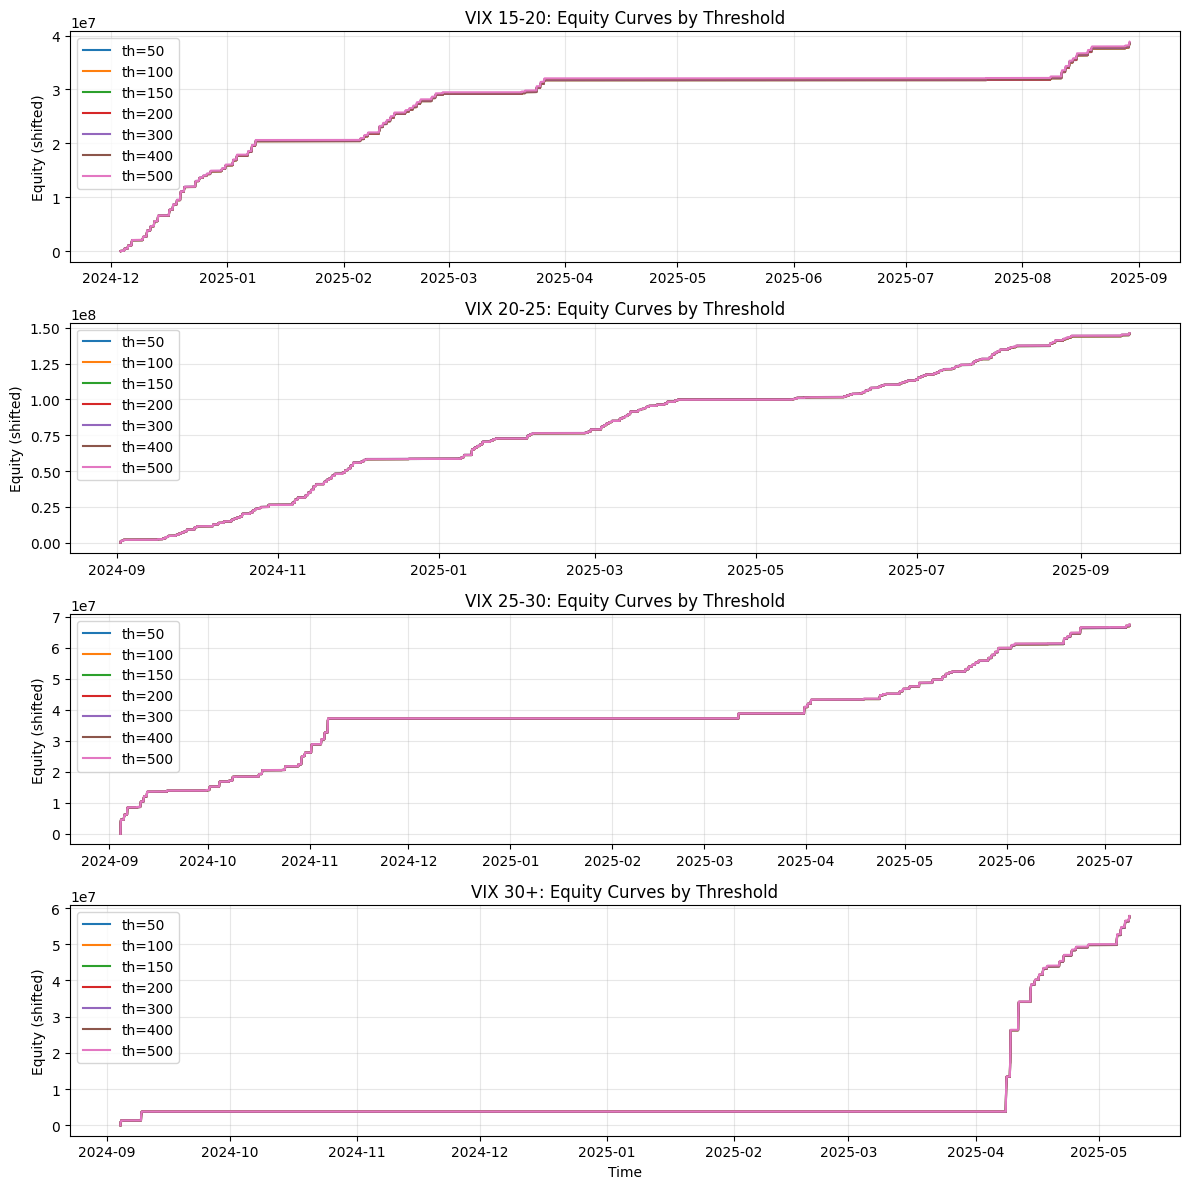

Per-bucket step PnL smoothness (lower std = smoother):
                  step_pnl_std  step_pnl_mean
bucket threshold                             
15-20  50.0        9131.231931    2722.486011
       100.0       9130.271151    2723.076392
       150.0       9128.917135    2724.424671
       200.0       9124.135046    2723.922475
       300.0       9146.083091    2730.553017
       400.0       9153.051113    2737.938270
       500.0       9192.589230    2750.495644
20-25  50.0       11619.863568    3988.114477
       100.0      11617.426505    3989.040191
       150.0      11620.873294    3988.823043
       200.0      11619.930369    3990.339524
       300.0      11666.769996    3997.297680
       400.0      11718.397650    3998.028110
       500.0      11789.222838    4000.529477
25-30  50.0       31803.152491    5627.115369
       100.0      31802.322116    5628.205471
       150.0      31804.313886    5629.021166
       200.0      31824.463275    5630.233414
       300.0      31832.5

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Per-bucket: plot all thresholds and show smoothness stats
if not bucket_results:
    print("bucket_results is empty; run the bucket analysis cell first.")
else:
    bucket_keys = sorted(bucket_results.keys(), key=lambda x: x[0])
    n = len(bucket_keys)
    fig, axes = plt.subplots(n, 1, figsize=(12, 3 * n), sharex=False)
    if n == 1:
        axes = [axes]
    smooth_records = []
    for ax, (low, high) in zip(axes, bucket_keys):
        data = bucket_results[(low, high)]
        all_results_bucket = data["all_results"]
        label_bucket = f"{int(low)}-{int(high)}" if np.isfinite(high) else f"{int(low)}+"
        for th, res in sorted(all_results_bucket.items()):
            curve = res["equity_curve"].copy()
            curve = curve - curve.iloc[0]  # shift start to 0
            ax.plot(curve.index, curve.values, label=f"th={th:.0f}")
            step_pnl = curve.diff().dropna()
            smooth_records.append({
                "bucket": label_bucket,
                "threshold": th,
                "step_pnl_std": step_pnl.std(),
                "step_pnl_mean": step_pnl.mean(),
            })
        ax.set_title(f"VIX {label_bucket}: Equity Curves by Threshold")
        ax.set_ylabel("Equity (shifted)")
        ax.grid(True, alpha=0.3)
        ax.legend()
    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    plt.show()

    # Smoothness table per bucket/threshold
    smooth_df_bucket = pd.DataFrame(smooth_records).sort_values(["bucket", "threshold"]).set_index(["bucket", "threshold"])
    print("Per-bucket step PnL smoothness (lower std = smoother):")
    print(smooth_df_bucket[["step_pnl_std", "step_pnl_mean"]])

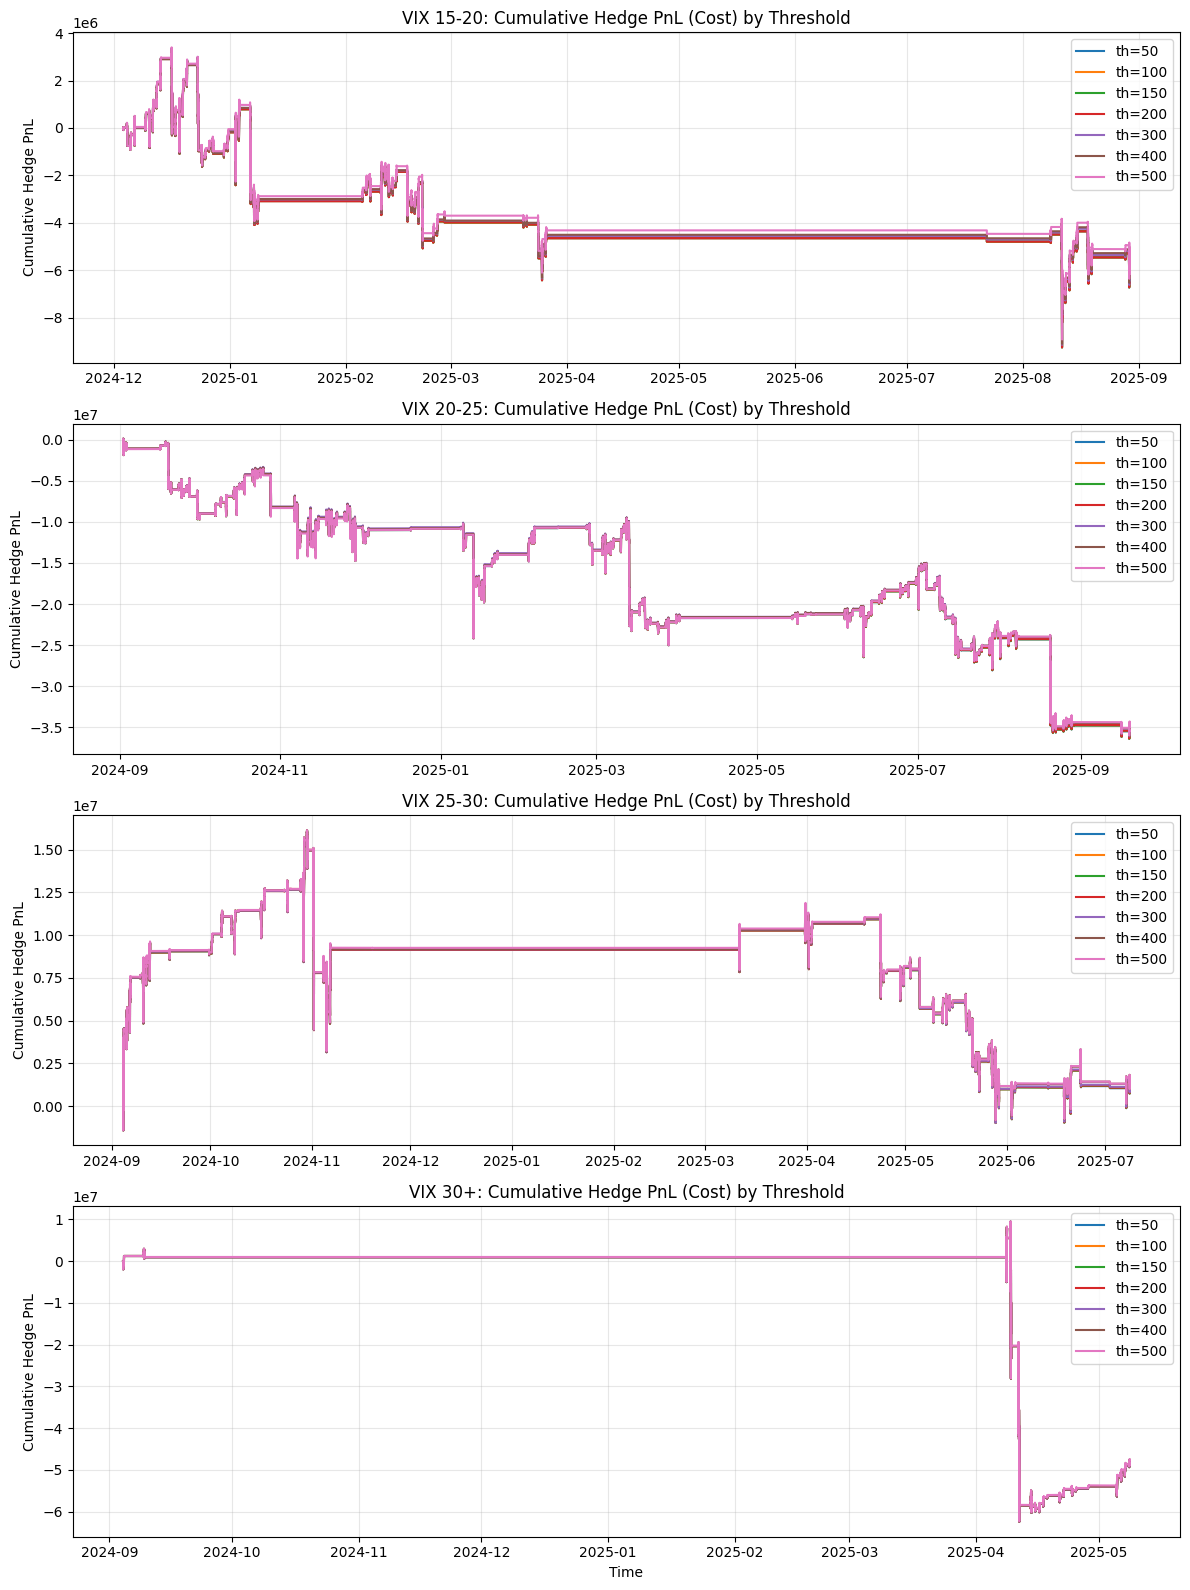

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Cumulative Hedge PnL Curves by VIX Bucket
# This shows the accumulation of hedge losses over time for each threshold in different volatility environments.

if 'bucket_results' in locals() and bucket_results:
    bucket_keys = sorted(bucket_results.keys(), key=lambda x: x[0])
    n = len(bucket_keys)
    fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n), sharex=False)
    if n == 1:
        axes = [axes]
    
    for ax, (low, high) in zip(axes, bucket_keys):
        data = bucket_results[(low, high)]
        all_results_bucket = data["all_results"]
        label_bucket = f"{int(low)}-{int(high)}" if np.isfinite(high) else f"{int(low)}+"
        
        for th, res in sorted(all_results_bucket.items()):
            # Extract cumulative hedge PnL
            if "details" in res and "hedge_pnl" in res["details"]:
                curve = res["details"]["hedge_pnl"].copy()
                if not curve.empty:
                    # Shift to start at 0 for clearer comparison of accumulation
                    curve = curve - curve.iloc[0]
                    ax.plot(curve.index, curve.values, label=f"th={th:.0f}")
        
        ax.set_title(f"VIX {label_bucket}: Cumulative Hedge PnL (Cost) by Threshold")
        ax.set_ylabel("Cumulative Hedge PnL")
        ax.grid(True, alpha=0.3)
        ax.legend()
        
    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    plt.show()
else:
    print("bucket_results not found. Please run the VIX bucket analysis cell first.")

In [25]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df2.index,
    y=df2['mkt_mid'],
    mode='lines',
    name='mkt_mid'
))

fig.update_layout(
    title='TXF Market Mid Price',
    xaxis_title='Time',
    yaxis_title='Price',
    hovermode='x unified'
)
fig.show()

Running analysis for: 2024 Sep-Dec (23310 rows)
  [2024 Sep-Dec] Interval 60m: Trades=3691, Hedge PnL=-10,760
  [2024 Sep-Dec] Interval 30m: Trades=5683, Hedge PnL=-1,032,080
  [2024 Sep-Dec] Interval 15m: Trades=8443, Hedge PnL=87,370
  [2024 Sep-Dec] Interval 15m: Trades=8443, Hedge PnL=87,370


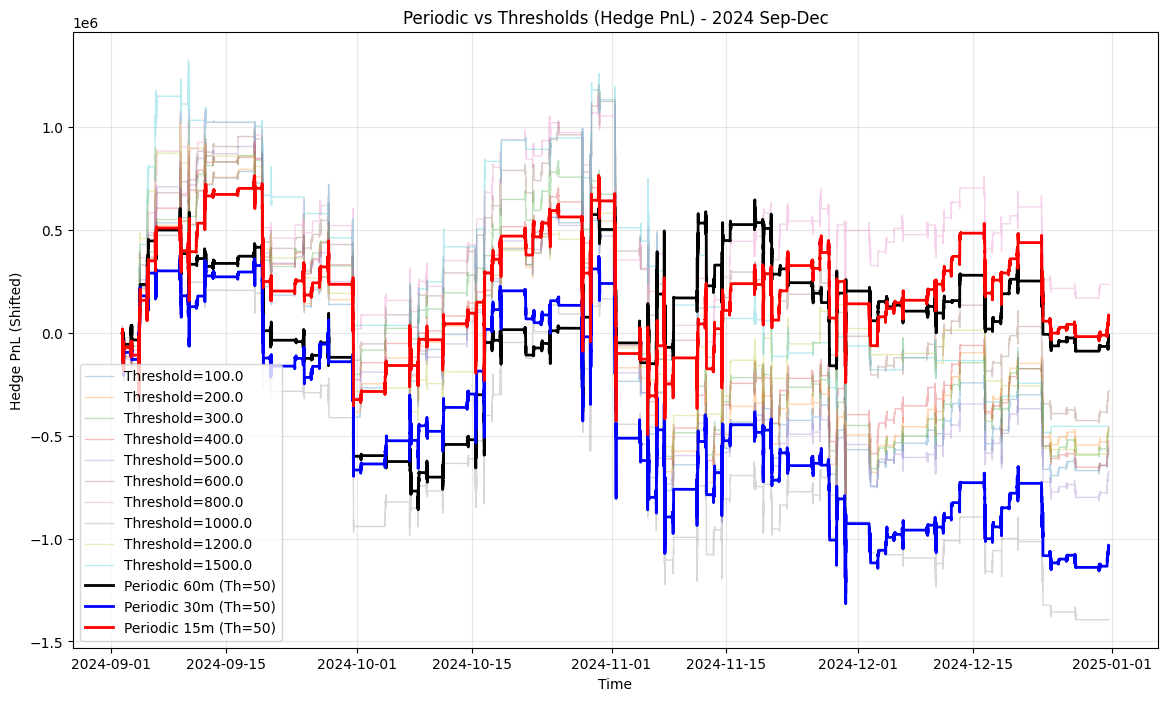

Running analysis for: 2025 Jan-Mar (15631 rows)
  [2025 Jan-Mar] Interval 60m: Trades=2137, Hedge PnL=-1,817,545
  [2025 Jan-Mar] Interval 30m: Trades=3292, Hedge PnL=-1,898,145
  [2025 Jan-Mar] Interval 15m: Trades=4819, Hedge PnL=-1,521,790
  [2025 Jan-Mar] Interval 15m: Trades=4819, Hedge PnL=-1,521,790


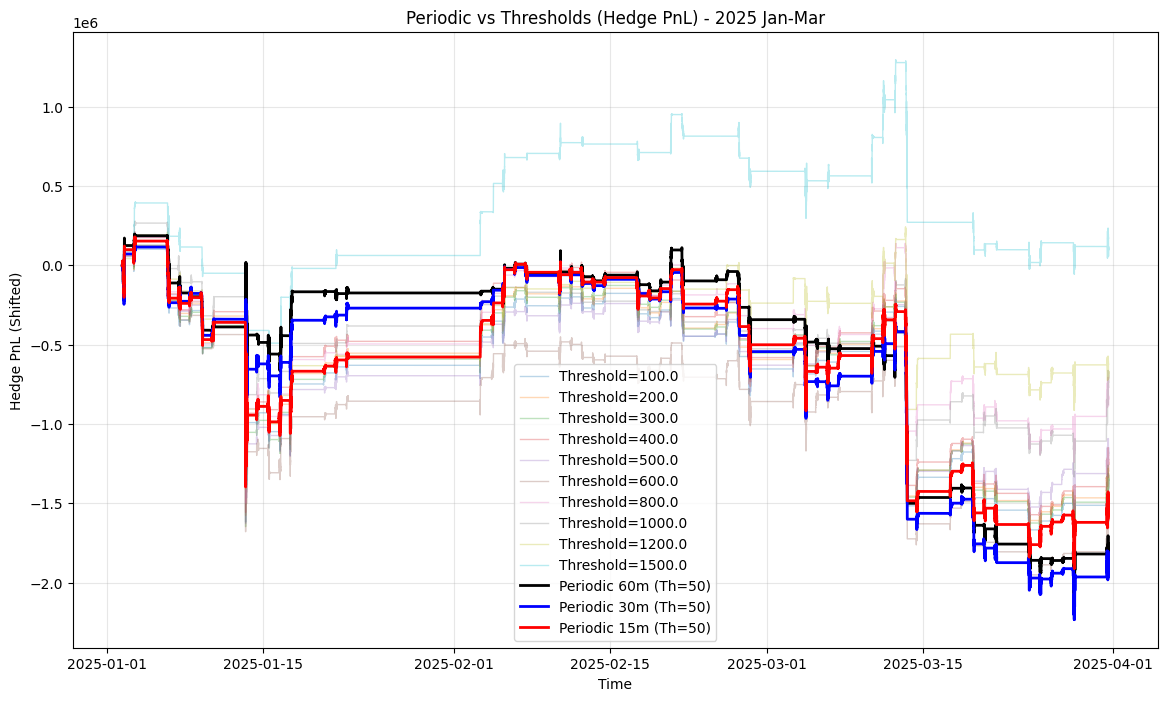

Running analysis for: 2025 May-Sep (24737 rows)
  [2025 May-Sep] Interval 60m: Trades=3636, Hedge PnL=628,565
  [2025 May-Sep] Interval 30m: Trades=5244, Hedge PnL=-564,990
  [2025 May-Sep] Interval 15m: Trades=7162, Hedge PnL=-835,620
  [2025 May-Sep] Interval 15m: Trades=7162, Hedge PnL=-835,620


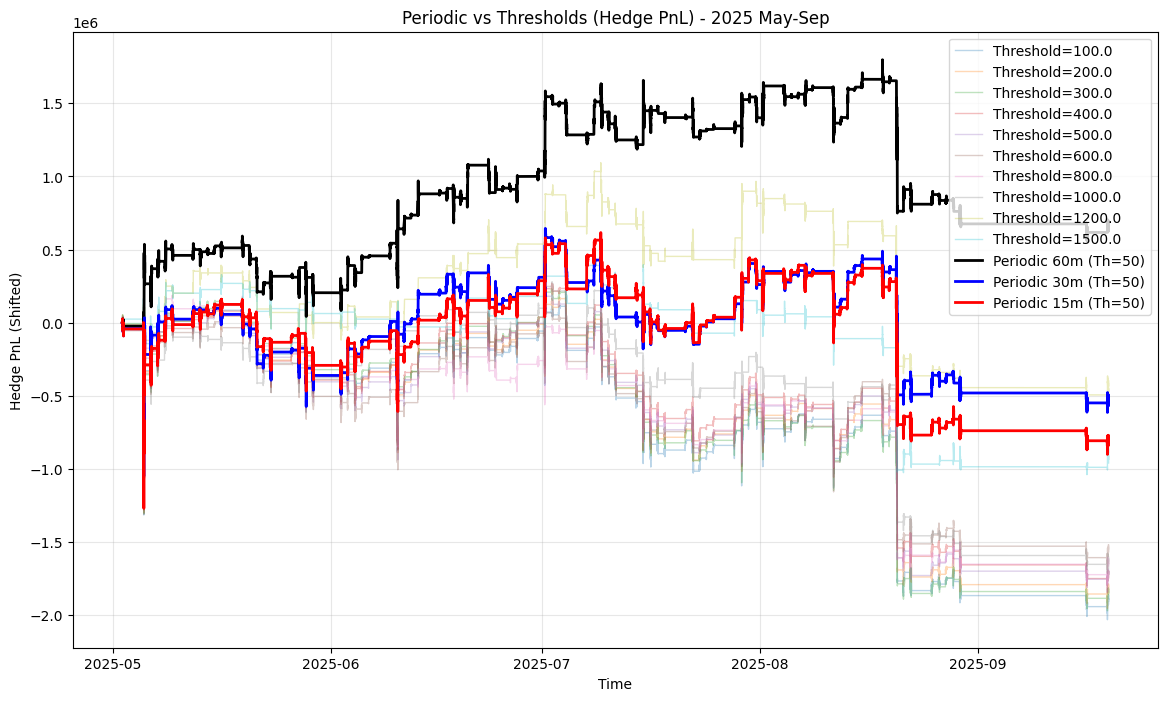

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define gamma_hedge_backtest_periodic
def gamma_hedge_backtest_periodic(
    df,
    price_col="price",
    gamma=10.0,
    min_delta_to_hedge=50.0,
    contract_multiplier=50.0,
    fee_per_contract=10.0,
    interval_minutes=60
):
    df = df.copy()
    
    if df.index.name == "time":
        df.index.name = "time_index"

    if "time" not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df["time"] = df.index
        else:
            raise ValueError("DataFrame must have a 'time' column or a DatetimeIndex.")
            
    df = df.sort_values("time")
    groups = df.groupby(df["time"].dt.date)

    total_gamma_pnl = 0.0
    cum_hedge_pnl = 0.0
    hedge_trades = 0

    equity_list = []
    equity_index = []
    records = []

    for _, group in groups:
        group = group.sort_values("time")
        prices = group[price_col].values
        times = group["time"].values
        
        # Pre-calculate period IDs for speed
        dt_index = pd.to_datetime(times)
        minutes_of_day = dt_index.hour * 60 + dt_index.minute
        period_ids = minutes_of_day // interval_minutes
        
        if len(prices) < 1:
            continue

        day_open = float(prices[0])
        fut_pos = 0.0
        last_price = day_open
        last_period_id = period_ids[0]

        for i in range(len(prices)):
            t = times[i]
            price_now = float(prices[i])
            dS = price_now - last_price

            # PnL Updates
            cum_hedge_pnl += fut_pos * dS * contract_multiplier
            day_gamma_pnl = 0.5 * gamma * (price_now - day_open) ** 2

            # Delta Calculation
            opt_delta = gamma * (price_now - day_open)
            fut_delta = fut_pos * contract_multiplier
            total_delta = opt_delta + fut_delta

            # Periodic Hedge Logic
            current_period_id = period_ids[i]
            is_period_change = (current_period_id != last_period_id)
            
            trade_size = 0
            
            if is_period_change:
                if abs(total_delta) >= min_delta_to_hedge:
                    ideal_fut_pos = -opt_delta / contract_multiplier
                    target_fut_pos = round(ideal_fut_pos)
                    
                    if target_fut_pos != fut_pos:
                        trade_size = abs(target_fut_pos - fut_pos)
                        fut_pos = target_fut_pos
                        
                        fut_delta = fut_pos * contract_multiplier
                        total_delta = opt_delta + fut_delta
                        
                        hedge_trades += trade_size
                        cum_hedge_pnl -= trade_size * fee_per_contract
                
                last_period_id = current_period_id

            # Record
            gamma_total = total_gamma_pnl + day_gamma_pnl
            total_equity = gamma_total + cum_hedge_pnl

            equity_list.append(total_equity)
            equity_index.append(t)
            
            records.append({
                "time": t,
                "price": price_now,
                "total_delta": total_delta,
                "hedge_pnl": cum_hedge_pnl,
                "equity": total_equity,
                "trade_size": trade_size
            })

            last_price = price_now

        final_day_gamma = 0.5 * gamma * (last_price - day_open) ** 2
        total_gamma_pnl += final_day_gamma

    return {
        "total_pnl": float(total_gamma_pnl + cum_hedge_pnl),
        "gamma_pnl": float(total_gamma_pnl),
        "hedge_pnl": float(cum_hedge_pnl),
        "hedge_trades": int(hedge_trades),
        "equity_curve": pd.Series(equity_list, index=equity_index),
        "details": pd.DataFrame(records).set_index("time"),
    }

# Split analysis into periods: 2024 Sep-Dec, 2025 Jan-Mar, 2025 May-Sep

def run_and_plot_periodic_comparison(target_df, period_name):
    if target_df.empty:
        print(f"No data for {period_name}")
        return

    print(f"Running analysis for: {period_name} ({len(target_df)} rows)")
    
    # 1. Run Periodic Strategies
    intervals = [60, 30, 15]
    periodic_results = {}
    
    for mins in intervals:
        res = gamma_hedge_backtest_periodic(
            df=target_df,
            price_col="mkt_mid",
            gamma=10.0,
            min_delta_to_hedge=50.0,
            contract_multiplier=50.0,
            interval_minutes=mins
        )
        periodic_results[mins] = res
        print(f"  [{period_name}] Interval {mins}m: Trades={res['hedge_trades']}, Hedge PnL={res['hedge_pnl']:,.0f}")

    # 2. Run Threshold Strategies (for comparison background)
    # We re-run thresholds on this specific subset to get correct PnL curves for this period
    thresholds = [100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 800.0, 1000.0, 1200.0, 1500.0]
    _, subset_threshold_results = run_gamma_hedge_new_pnl_thresholds(
        df=target_df,
        price_col="mkt_mid",
        gamma=10.0,
        delta_thresholds=thresholds,
        contract_multiplier=50.0
    )

    # 3. Plot
    plt.figure(figsize=(14, 8))
    
    # Plot Thresholds (Background)
    for th, res in subset_threshold_results.items():
        if 'details' in res and 'hedge_pnl' in res['details']:
            h_curve = res['details']['hedge_pnl']
            # Shift to 0 for comparison
            if not h_curve.empty:
                h_curve = h_curve - h_curve.iloc[0]
                plt.plot(h_curve.index, h_curve.values, label=f'Threshold={th}', linestyle='-', alpha=0.3, linewidth=1)

    # Plot Periodic
    colors = {60: 'black', 30: 'blue', 15: 'red'}
    for mins in intervals:
        res = periodic_results[mins]
        h_curve = res['details']['hedge_pnl']
        # Shift to 0 for comparison
        if not h_curve.empty:
            h_curve = h_curve - h_curve.iloc[0]
            plt.plot(h_curve.index, h_curve.values, label=f'Periodic {mins}m (Th=50)', linewidth=2, color=colors.get(mins, 'green'))

    plt.title(f"Periodic vs Thresholds (Hedge PnL) - {period_name}")
    plt.xlabel("Time")
    plt.ylabel("Hedge PnL (Shifted)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Define periods
# 2024 Sep-Dec
df_2024_sep_dec = df2[(df2.index.year == 2024) & (df2.index.month.isin([9, 10, 11, 12]))].copy()

# 2025 Jan-Mar
df_jan_mar = df2[(df2.index.year == 2025) & (df2.index.month.isin([1, 2, 3]))].copy()

# 2025 May-Sep
df_may_sep = df2[(df2.index.year == 2025) & (df2.index.month.isin([5, 6, 7, 8, 9]))].copy()

# Execute
run_and_plot_periodic_comparison(df_2024_sep_dec, "2024 Sep-Dec")
run_and_plot_periodic_comparison(df_jan_mar, "2025 Jan-Mar")
run_and_plot_periodic_comparison(df_may_sep, "2025 May-Sep")

Running VIX Analysis for ALL Data (Periodic vs Threshold)
  Processing VIX 15-20 (14119 rows)...


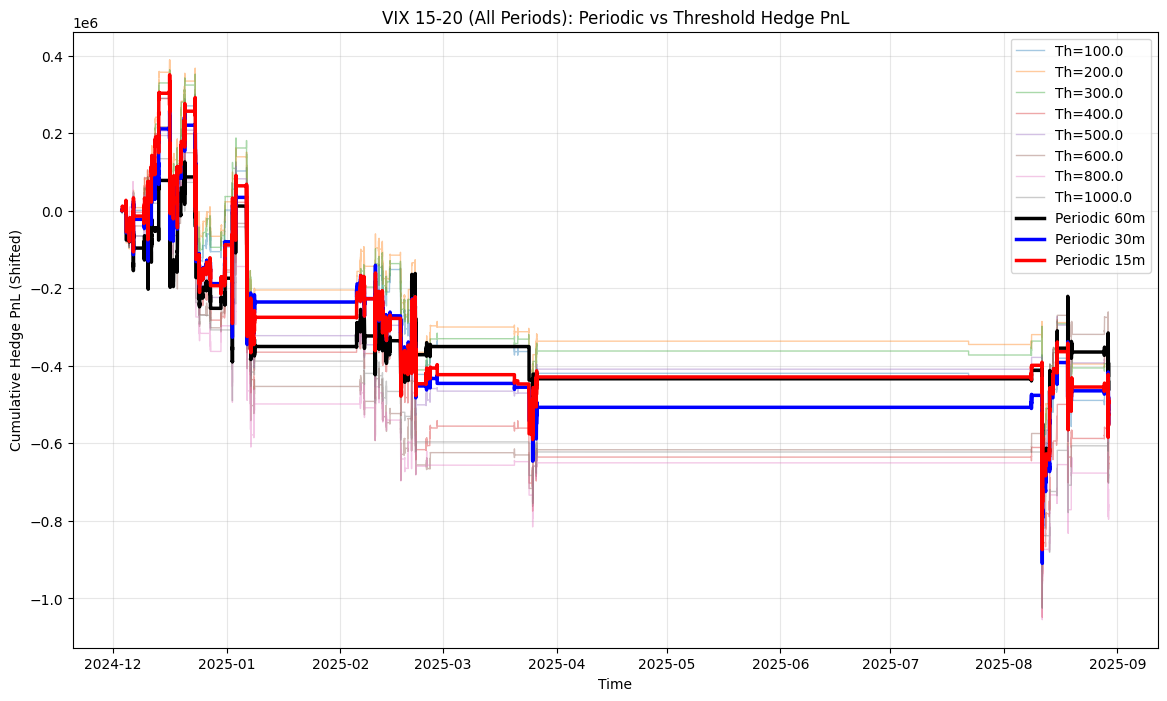

  Processing VIX 20-25 (36589 rows)...


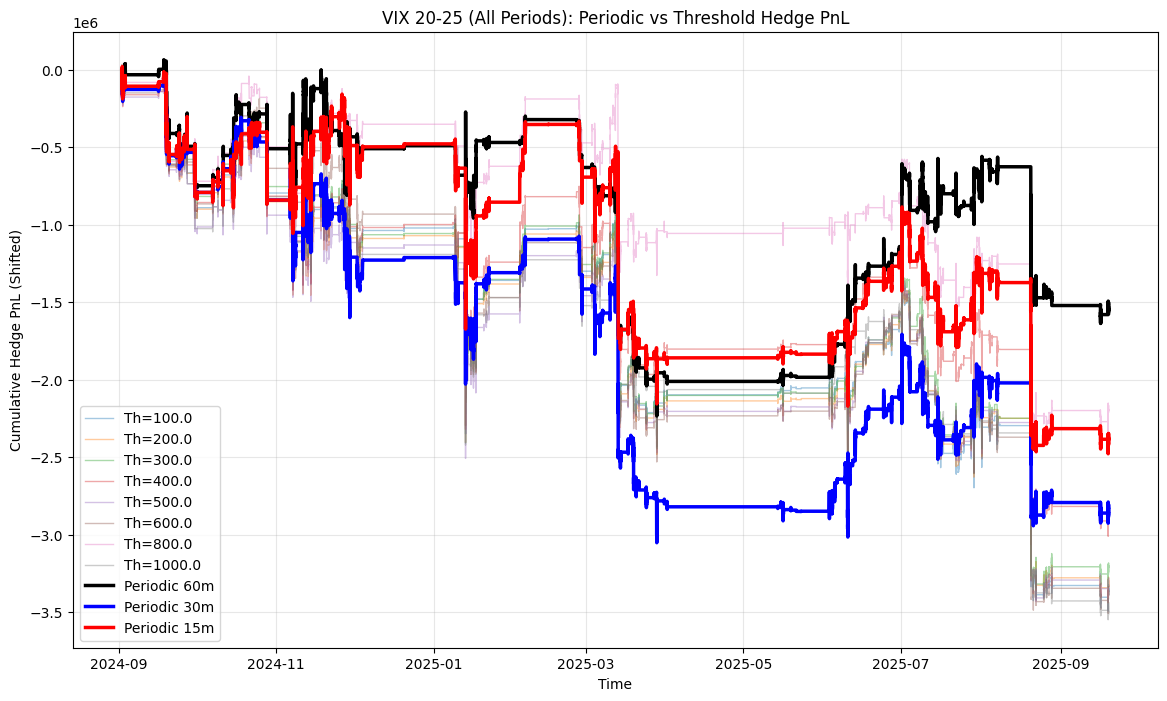

  Processing VIX 25-30 (11954 rows)...


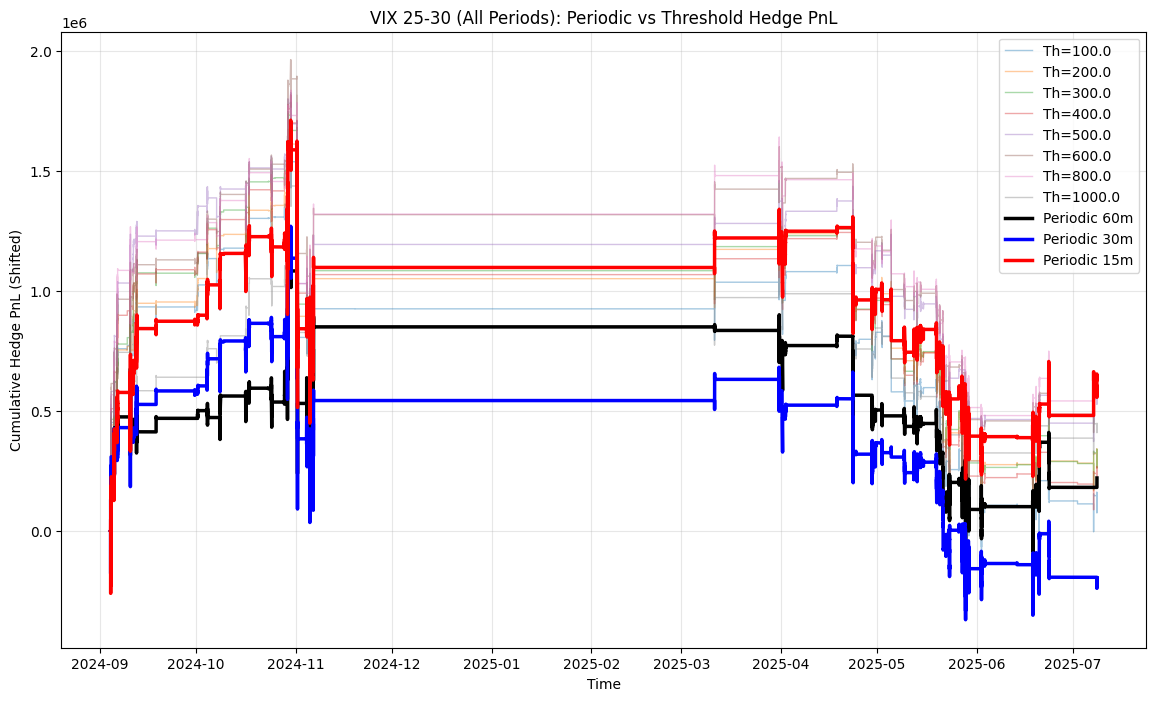

  Processing VIX 30+ (5384 rows)...


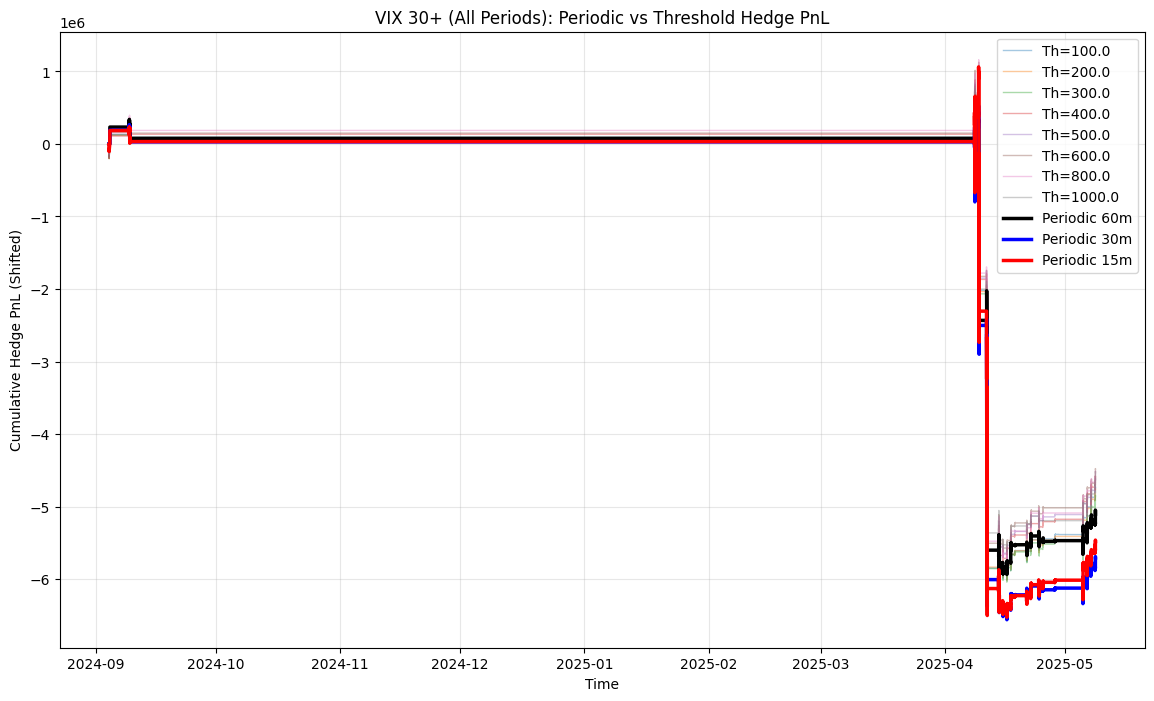


=== Strategy Performance by VIX Bucket ===

[Daily Total PnL Std] (Volatility of Equity)
VIX                  15-20          20-25          25-30            30+
Strategy                                                               
Periodic 15m  41140.104177   76397.605309   97557.529472  302835.827671
Periodic 30m  46957.910483   88655.331202   97564.166998  321029.791366
Periodic 60m  58980.175104  129915.770143  119044.120621  368908.980489
Th=100.0      31477.126664   55193.950378   91021.246372  330193.411526
Th=200.0      33906.346343   55828.398734   93708.612776  334000.344857
Th=300.0      35982.322490   57425.514964   95017.653356  333976.364473
Th=400.0      36117.105254   62764.980170   97554.836653  351133.807479
Th=500.0      43487.900973   62699.223615  108909.255440  370359.165056
Th=600.0      42496.904249   61410.746734  115266.821582  358994.067950
Th=800.0      45617.202995   77098.988733  116608.148691  359774.304761
Th=1000.0     56631.598054   78975.765132  102

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def calc_risk_metrics(res):
    d_std = np.nan
    h_std = np.nan
    sharpe = np.nan
    n_days = 0
    
    if 'equity_curve' in res and not res['equity_curve'].empty:
        # Ensure index is datetime
        curve = res['equity_curve']
        if not isinstance(curve.index, pd.DatetimeIndex):
            curve.index = pd.to_datetime(curve.index)
            
        # Total PnL Daily Series
        daily_cum = curve.resample('D').last().dropna()
        n_days = len(daily_cum)
        
        if len(daily_cum) > 1:
            daily_pnl = daily_cum.diff()
            # Fill the first NaN with the first cumulative value (assuming start from 0)
            if not daily_cum.empty:
                daily_pnl.iloc[0] = daily_cum.iloc[0]
            
            # Drop any remaining NaNs just in case
            daily_pnl = daily_pnl.dropna()
            
            if len(daily_pnl) > 1:
                d_mean = daily_pnl.mean()
                d_std = daily_pnl.std()
                
                annual_factor = np.sqrt(252)
                
                if d_std > 1e-9:
                    sharpe = (d_mean / d_std) * annual_factor
        
    # Hedge PnL Std
    if 'details' in res and 'hedge_pnl' in res['details']:
        h_curve = res['details']['hedge_pnl']
        if not isinstance(h_curve.index, pd.DatetimeIndex):
            h_curve.index = pd.to_datetime(h_curve.index)
            
        if not h_curve.empty:
            h_daily_cum = h_curve.resample('D').last().dropna()
            if len(h_daily_cum) > 1:
                h_daily_pnl = h_daily_cum.diff()
                h_daily_pnl.iloc[0] = h_daily_cum.iloc[0]
                h_std = h_daily_pnl.std()
            
    return d_std, h_std, sharpe, n_days

def run_vix_split_analysis_all(target_df, vix_df):
    if target_df.empty:
        print("No data provided")
        return

    print("Running VIX Analysis for ALL Data (Periodic vs Threshold)")

    # 1. Prepare Data & Merge VIX
    temp_df = target_df.copy()
    if temp_df.index.name == "time":
        temp_df.index.name = "time_index"
    if "time" not in temp_df.columns:
        temp_df["time"] = temp_df.index
    
    v_df = vix_df.copy()
    if "time" not in v_df.columns:
        if isinstance(v_df.index, pd.DatetimeIndex):
            v_df["time"] = v_df.index
    
    temp_df = temp_df.sort_values("time")
    v_df = v_df.sort_values("time")
    
    # Detect VIX col
    vix_col = None
    for c in ["vix_like", "vix", "VIX", "vix_close", "close_vix"]:
        if c in v_df.columns:
            vix_col = c
            break
    if not vix_col:
        print("VIX column not found")
        return

    merged = pd.merge_asof(temp_df, v_df[["time", vix_col]], on="time", direction="nearest", tolerance=pd.Timedelta("2min"))
    merged = merged.dropna(subset=[vix_col])

    # 2. Define Buckets
    buckets = [
        (15, 20),
        (20, 25),
        (25, 30),
        (30, np.inf),
    ]

    # Store stats
    all_stats = []

    # 3. Analyze per Bucket
    for low, high in buckets:
        if np.isfinite(high):
            mask = (merged[vix_col] >= low) & (merged[vix_col] < high)
            label_bucket = f"{int(low)}-{int(high)}"
        else:
            mask = merged[vix_col] >= low
            label_bucket = f"{int(low)}+"

        sub_df = merged.loc[mask].copy()
        if sub_df.empty:
            print(f"  VIX {label_bucket}: No data")
            continue
            
        print(f"  Processing VIX {label_bucket} ({len(sub_df)} rows)...")
        
        # Calculate Initial Capital for Log Return
        contract_multiplier = 50.0
        if "mkt_mid" in sub_df.columns:
            initial_price = sub_df["mkt_mid"].iloc[0]
        elif "price" in sub_df.columns:
            initial_price = sub_df["price"].iloc[0]
        else:
            initial_price = 0.0
            
        initial_capital = initial_price * contract_multiplier

        # --- A. Run Periodic Strategies ---
        intervals = [60, 30, 15]
        periodic_results = {}
        for mins in intervals:
            res = gamma_hedge_backtest_periodic(
                df=sub_df,
                price_col="mkt_mid",
                gamma=10.0,
                min_delta_to_hedge=50.0,
                contract_multiplier=contract_multiplier,
                interval_minutes=mins
            )
            periodic_results[mins] = res
            
            # Calc Stats
            d_std, h_std, sharpe, n_days = calc_risk_metrics(res)
            
            # Calc Log Return
            cum_pnl = res["total_pnl"]
            if initial_capital > 0:
                cum_log_ret = np.log(max(1 + cum_pnl / initial_capital, 1e-9))
            else:
                cum_log_ret = 0.0
            
            all_stats.append({
                "VIX": label_bucket,
                "Strategy": f"Periodic {mins}m",
                "Daily_Total_PnL_Std": d_std,
                "Daily_Hedge_PnL_Std": h_std,
                "Total_PnL": cum_pnl,
                "Cumulative_Log_Return": cum_log_ret,
                "Sharpe_Ratio": sharpe,
                "N_Days": n_days
            })

        # --- B. Run Threshold Strategies ---
        thresholds = [100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 800.0, 1000.0]
        _, subset_results = run_gamma_hedge_new_pnl_thresholds(
            df=sub_df,
            price_col="mkt_mid",
            gamma=10.0,
            delta_thresholds=thresholds,
            contract_multiplier=contract_multiplier
        )
        
        for th, res in subset_results.items():
             # Calc Stats
            d_std, h_std, sharpe, n_days = calc_risk_metrics(res)
            
            # Calc Log Return
            cum_pnl = res["total_pnl"]
            if initial_capital > 0:
                cum_log_ret = np.log(max(1 + cum_pnl / initial_capital, 1e-9))
            else:
                cum_log_ret = 0.0
                
            all_stats.append({
                "VIX": label_bucket,
                "Strategy": f"Th={th}",
                "Daily_Total_PnL_Std": d_std,
                "Daily_Hedge_PnL_Std": h_std,
                "Total_PnL": cum_pnl,
                "Cumulative_Log_Return": cum_log_ret,
                "Sharpe_Ratio": sharpe,
                "N_Days": n_days
            })

        # --- C. Plot ---
        plt.figure(figsize=(14, 8))
        has_plot_data = False
        
        # Plot Thresholds (Background, thinner lines)
        for th, res in subset_results.items():
            if 'details' in res and 'hedge_pnl' in res['details']:
                h_curve = res['details']['hedge_pnl']
                if not h_curve.empty:
                    h_curve = h_curve - h_curve.iloc[0]
                    plt.plot(h_curve.index, h_curve.values, label=f'Th={th}', alpha=0.4, linewidth=1)
                    has_plot_data = True

        # Plot Periodic (Foreground, thicker lines)
        colors = {60: 'black', 30: 'blue', 15: 'red'}
        for mins in intervals:
            res = periodic_results[mins]
            h_curve = res['details']['hedge_pnl']
            if not h_curve.empty:
                h_curve = h_curve - h_curve.iloc[0]
                plt.plot(h_curve.index, h_curve.values, label=f'Periodic {mins}m', linewidth=2.5, color=colors.get(mins, 'green'))
                has_plot_data = True

        if has_plot_data:
            plt.title(f"VIX {label_bucket} (All Periods): Periodic vs Threshold Hedge PnL")
            plt.xlabel("Time")
            plt.ylabel("Cumulative Hedge PnL (Shifted)")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
        else:
            plt.close()

    # Print Stats Table
    if all_stats:
        stats_df = pd.DataFrame(all_stats)
        
        # Custom Sort Logic for Strategy Index
        def strategy_sort_key(s):
            # 1. Periodic first, sorted by minutes (ascending)
            if s.startswith("Periodic"):
                try:
                    mins = int(s.split()[1].replace('m', ''))
                    return (0, mins)
                except:
                    return (0, 9999)
            # 2. Thresholds next, sorted by value (ascending)
            elif s.startswith("Th="):
                try:
                    val = float(s.split('=')[1])
                    return (1, val)
                except:
                    return (1, 9999)
            # 3. Others
            return (2, 0)

        # Get unique strategies and sort them
        unique_strategies = stats_df["Strategy"].unique()
        sorted_strategies = sorted(unique_strategies, key=strategy_sort_key)

        print("\n=== Strategy Performance by VIX Bucket ===")
        
        # Pivot for Total PnL Std
        pivot_total = stats_df.pivot(index="Strategy", columns="VIX", values="Daily_Total_PnL_Std")
        pivot_total = pivot_total.reindex(sorted_strategies)
        print("\n[Daily Total PnL Std] (Volatility of Equity)")
        print(pivot_total)
        
        # Pivot for Total PnL
        pivot_pnl = stats_df.pivot(index="Strategy", columns="VIX", values="Total_PnL")
        pivot_pnl = pivot_pnl.reindex(sorted_strategies)
        print("\n[Total PnL] (Cumulative Profit/Loss)")
        print(pivot_pnl)
        
        # Pivot for Cumulative Log Return
        pivot_log_ret = stats_df.pivot(index="Strategy", columns="VIX", values="Cumulative_Log_Return")
        pivot_log_ret = pivot_log_ret.reindex(sorted_strategies)
        print("\n[Cumulative Log Return] (Total Return)")
        print(pivot_log_ret)
        
        # Pivot for Sharpe Ratio
        pivot_sharpe = stats_df.pivot(index="Strategy", columns="VIX", values="Sharpe_Ratio")
        pivot_sharpe = pivot_sharpe.reindex(sorted_strategies)
        
        # Add Sample Size row
        n_days_per_bucket = stats_df.groupby("VIX")["N_Days"].max()
        pivot_sharpe.loc["Sample Size (Days)"] = n_days_per_bucket
        
        print("\n[Sharpe Ratio] (Annualized)")
        print(pivot_sharpe)

# Execute for ALL data
if 'df' in locals() and 'df2' in locals():
    run_vix_split_analysis_all(df2, df)
else:
    print("Dataframes 'df' (VIX) or 'df2' (Prices) not found.")